In [ ]:
!pip install -U lhotse

In [3]:
import lhotse

In [62]:
from lhotse.recipes.librispeech import download_librispeech, prepare_librispeech
LS_PARTS = ['train-clean-5']
download_librispeech(dataset_parts=LS_PARTS)

train-clean-5.tar.gz:   0%|          | 0.00/333M [00:00<?, ?B/s]

PosixPath('LibriSpeech')

In [63]:
manifests = prepare_librispeech(corpus_dir='LibriSpeech', dataset_parts=LS_PARTS, output_dir='data')

manifests

Dataset parts:   0%|          | 0/1 [00:00<?, ?it/s]

Distributing tasks: 0it [00:00, ?it/s]

Processing:   0%|          | 0/1519 [00:00<?, ?it/s]

{'train-clean-5': {'recordings': RecordingSet(len=1519),
  'supervisions': SupervisionSet(len=1519)}}

In [65]:
from lhotse import RecordingSet

recordings = RecordingSet.from_jsonl('/content//data//librispeech_recordings_train-clean-5.jsonl.gz')

# Alternatively:
# recordings = manifests['dev-clean-2']['recordings']

print(f'There are {len(recordings)} recordings.')


There are 1519 recordings.


In [67]:
audio = recordings[0].load_audio()
print(type(audio), 'with shape', audio.shape)

<class 'numpy.ndarray'> with shape (1, 246080)


In [71]:
from lhotse import SupervisionSet

supervisions = SupervisionSet.from_jsonl('/content//data//librispeech_supervisions_train-clean-5.jsonl.gz')
print(f'There are {len(supervisions)} recordings.')


There are 1519 recordings.


In [72]:
from lhotse import CutSet

cuts = CutSet.from_manifests(recordings, supervisions)
cuts

CutSet(len=1519) [underlying data type: <class 'dict'>]

In [73]:
cut = cuts[0]
for item in (cut.id, cut.duration, cut.sampling_rate, cut.recording_id, cut.supervisions):
    print(item)

332-128985-0000-0
15.38
16000
332-128985-0000
[SupervisionSegment(id='332-128985-0000', recording_id='332-128985-0000', start=0.0, duration=15.38, channel=0, text='WE WILL PASS TO THE CONSIDERATION OF A REGULAR OUT AND OUT PIRATE ONE FROM WHOSE MAST HEAD WOULD HAVE FLOATED THE BLACK FLAG WITH ITS SKULL AND CROSS BONES IF THAT EMBLEMATIC PIECE OF BUNTING HAD BEEN IN USE BY THE PIRATES OF THE PERIOD', language='English', speaker='332', gender=None, custom=None, alignment=None)]


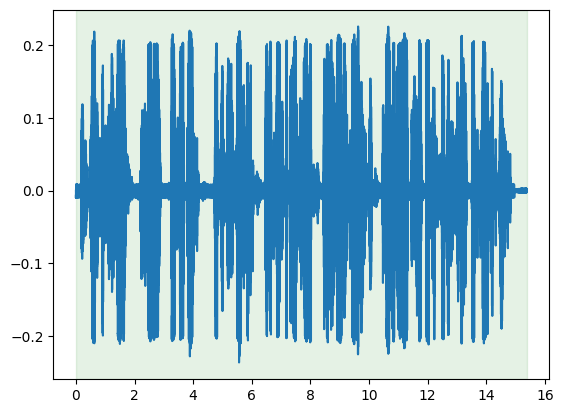

In [74]:
cut.plot_audio()
cut.play_audio()

<Axes: >

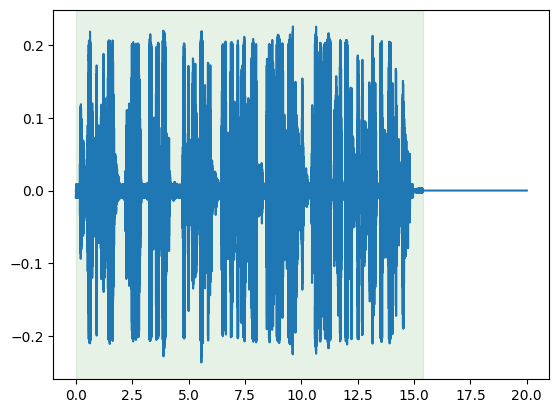

In [75]:
cut.pad(duration=20).plot_audio()

<Axes: >

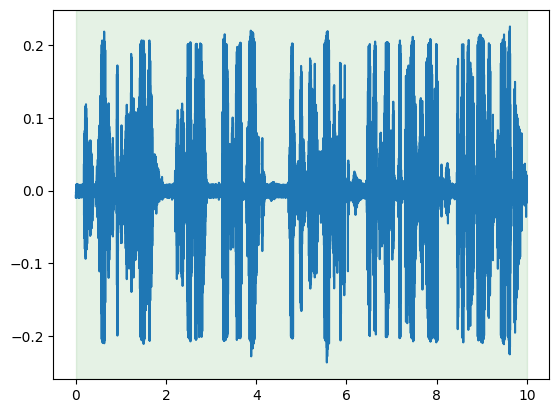

In [76]:
cut.truncate(duration=10).plot_audio()

In [77]:
from lhotse import Fbank, FbankConfig

fbank = Fbank(config=FbankConfig(num_mel_bins=80))

for example_cut in (cut, cut.truncate(duration=5), cut.pad(duration=30)):
    feats = example_cut.compute_features(extractor=fbank)
    print(type(feats), 'with shape', feats.shape)

<class 'numpy.ndarray'> with shape (1538, 80)
<class 'numpy.ndarray'> with shape (500, 80)
<class 'numpy.ndarray'> with shape (3000, 80)


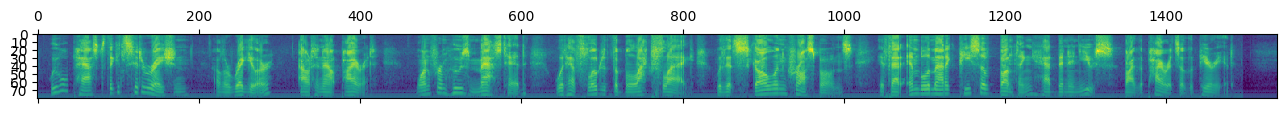

In [78]:
from lhotse import LilcomFilesWriter
storage = LilcomFilesWriter('make_feats')
cut = cut.compute_and_store_features(extractor=fbank, storage=storage)

cut.plot_features()
cut.play_audio()

In [79]:
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
Pathlike='/content'
with ProcessPoolExecutor(4, mp_context=multiprocessing.get_context("spawn")) as ex:
    cuts = cuts.compute_and_store_features(extractor=fbank, storage_path=Pathlike, executor=ex).pad()

Extracting and storing features:   0%|          | 0/1519 [00:00<?, ?it/s]

In [80]:
from lhotse.dataset.speech_synthesis import SpeechSynthesisDataset

dataset = SpeechSynthesisDataset(cuts)


In [81]:
dataset

In [82]:
from torch.utils.data import DataLoader

In [83]:
dataset.cuts[0]

MixedCut(id='e0e9436a-dee1-4a25-89fb-85c1a06ab6f5', tracks=[MixTrack(cut=MonoCut(id='332-128985-0000-0', start=0, duration=15.38, channel=0, supervisions=[SupervisionSegment(id='332-128985-0000', recording_id='332-128985-0000', start=0.0, duration=15.38, channel=0, text='WE WILL PASS TO THE CONSIDERATION OF A REGULAR OUT AND OUT PIRATE ONE FROM WHOSE MAST HEAD WOULD HAVE FLOATED THE BLACK FLAG WITH ITS SKULL AND CROSS BONES IF THAT EMBLEMATIC PIECE OF BUNTING HAD BEEN IN USE BY THE PIRATES OF THE PERIOD', language='English', speaker='332', gender=None, custom=None, alignment=None)], features=Features(type='kaldi-fbank', num_frames=1538, num_features=80, frame_shift=0.01, sampling_rate=16000, start=0, duration=15.38, storage_type='lilcom_chunky', storage_path='/content.lca', storage_key='0,45547,44299,45329,3821', recording_id='None', channels=0), recording=Recording(id='332-128985-0000', sources=[AudioSource(type='file', channels=[0], source='LibriSpeech/train-clean-5/332/128985/332-12

In [84]:
from torch.utils.data import Dataset, DataLoader, random_split
dataset = SpeechSynthesisDataset(cuts=cuts)
#train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [85]:
dataset

In [98]:
data=dataset.cuts.data

In [99]:
data=data['e0e9436a-dee1-4a25-89fb-85c1a06ab6f5']


In [100]:
data

MixedCut(id='e0e9436a-dee1-4a25-89fb-85c1a06ab6f5', tracks=[MixTrack(cut=MonoCut(id='332-128985-0000-0', start=0, duration=15.38, channel=0, supervisions=[SupervisionSegment(id='332-128985-0000', recording_id='332-128985-0000', start=0.0, duration=15.38, channel=0, text='WE WILL PASS TO THE CONSIDERATION OF A REGULAR OUT AND OUT PIRATE ONE FROM WHOSE MAST HEAD WOULD HAVE FLOATED THE BLACK FLAG WITH ITS SKULL AND CROSS BONES IF THAT EMBLEMATIC PIECE OF BUNTING HAD BEEN IN USE BY THE PIRATES OF THE PERIOD', language='English', speaker='332', gender=None, custom=None, alignment=None)], features=Features(type='kaldi-fbank', num_frames=1538, num_features=80, frame_shift=0.01, sampling_rate=16000, start=0, duration=15.38, storage_type='lilcom_chunky', storage_path='/content.lca', storage_key='0,45547,44299,45329,3821', recording_id='None', channels=0), recording=Recording(id='332-128985-0000', sources=[AudioSource(type='file', channels=[0], source='LibriSpeech/train-clean-5/332/128985/332-12

In [95]:
data.supervisions[0].text

'WE WILL PASS TO THE CONSIDERATION OF A REGULAR OUT AND OUT PIRATE ONE FROM WHOSE MAST HEAD WOULD HAVE FLOATED THE BLACK FLAG WITH ITS SKULL AND CROSS BONES IF THAT EMBLEMATIC PIECE OF BUNTING HAD BEEN IN USE BY THE PIRATES OF THE PERIOD'